In [1]:
import pandas as pd
from IPython.display import HTML
import fargopy as fp
import numpy as np 
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.integrate import solve_ivp
from celluloid import Camera  
from joblib import Parallel, delayed
from tqdm_joblib import tqdm_joblib
from tqdm import tqdm
from matplotlib.animation import FFMpegWriter




Running FARGOpy version 0.3.12


In [2]:

#Cargar los datos de la simulación de Matias
DIR = "/home/jupitergeci/fargowork/data/fargo_data/"
sim = fp.Simulation(output_dir = DIR)

# Descargar los datos del preset P3DISO
#fp.Simulation.download_precomputed('p3disoj')
#sim = fp.Simulation(output_dir='/tmp/p3disoj')

Your simulation is now connected with '/home/jupitergeci/fargo3d/'
Now you are connected with output directory '/home/jupitergeci/fargowork/data/fargo_data/'
Found a variables.par file in '/home/jupitergeci/fargowork/data/fargo_data/', loading properties
Loading variables
84 variables loaded
Simulation in 3 dimensions
Loading domain in spherical coordinates:
	Variable phi: 256 [[0, -1.564660403643354], [-1, 1.564660403643354]]
	Variable r: 128 [[0, 0.50390625], [-1, 1.49609375]]
	Variable theta: 32 [[0, 1.44319539835739], [-1, 1.5687709152323963]]
Number of snapshots in output directory: 216
Configuration variables and domains load into the object. See e.g. <sim>.vars


# Funciones Interpolación


# Interpolación Espacial en Malla Irregular

Para interpolar un campo en una malla irregular, utilizamos la función `griddata` de SciPy, 
la cual permite interpolar valores en puntos arbitrarios a partir de un conjunto de datos discretos. 
Dado un conjunto de puntos $(x_i, y_i)$ y valores asociados $f(x_i, y_i)$, la interpolación espacial
en un punto $(x, y)$ se obtiene resolviendo:

$$
f(x, y) \approx \sum_{i=1}^{N} w_i f(x_i, y_i)
$$

donde los pesos $w_i$ dependen del método de interpolación.

---

# Interpolación Temporal entre Snapshots

Dado un conjunto de snapshots a tiempos discretos $t_0, t_1, \dots,
 t_N$ con valores del campo $\varphi(t_i)$ en cada uno, interpolamos un valor intermedio $\varphi(t)$ en un tiempo $t$ con la interpolación lineal:

$$
\varphi(t) = \frac{t - t_i}{t_{i+1} - t_i} \varphi(t_{i+1}) + \left(1 - \frac{t - t_i}{t_{i+1} - t_i} \right) \varphi(t_i), \quad t_i \leq t \leq t_{i+1}
$$




Primero se interpola en espacio y luego en tiempo
analogía con metodo linear 


In [3]:
def load_data(PLANE, ANGLE, NUM_SNAPSHOTS):
    """
    Carga y organiza datos de velocidad y densidad del gas en un plano específico de la simulación.
    
    Parámetros:
    - PLANE (str): Plano de corte ('XZ', 'XY' o 'YZ').
    - ANGLE (float): Ángulo o posición específica del corte (por ahora solo esféricas r, theta, phi). 
    - NUM_SNAPSHOTS (int): Número total de snapshots en la simulación.
    
    Retorna:
    - pd.DataFrame: DataFrame con columnas ['snapshot', 'time', 'vel1', 'vel2', 'gasdens', 'coord1', 'coord2'].
    
    """
    snapshots = np.arange(1, NUM_SNAPSHOTS + 1)
    time_values = snapshots / NUM_SNAPSHOTS

    df_snapshots = pd.DataFrame(columns=["snapshot", "time", "vel1", "vel2", "gasdens", "coord1", "coord2"])

    for i, snap in enumerate(snapshots):
        gasv = sim.load_field('gasv', snapshot=snap, type='vector')
        gasvx, gasvy, gasvz = gasv.to_cartesian()
        gasd = sim.load_field('gasdens', snapshot=snap, type='scalar')
        
        if PLANE == 'XZ':
            vel1_slice, mesh = gasvx.meshslice(slice=ANGLE)
            vel2_slice, _ = gasvz.meshslice(slice=ANGLE)
            coord1, coord2 = mesh.x, mesh.z
        elif PLANE == 'XY':
            vel1_slice, mesh = gasvx.meshslice(slice=ANGLE)
            vel2_slice, _ = gasvy.meshslice(slice=ANGLE)
            coord1, coord2 = mesh.x, mesh.y
        elif PLANE == 'YZ':
            vel1_slice, mesh = gasvy.meshslice(slice='r=1.0')
            vel2_slice, _ = gasvz.meshslice(slice='r=1.0')
            coord1, coord2 = mesh.y, mesh.z
        
        gasd_slice, _ = gasd.meshslice(slice=ANGLE)
        df_snapshots.loc[i] = [snap, time_values[i], vel1_slice, vel2_slice, gasd_slice, coord1, coord2]
    
    return df_snapshots

def interpolate_field(time, var1, var2, df, field_name):
    """
    Interpola un campo escalar o vectorial en el tiempo y el espacio.
    
    Parámetros:
    - time (float): Tiempo de interpolación.
    - var1, var2 (float): Coordenadas espaciales.
    - df (pd.DataFrame): DataFrame con los datos de la simulación.
    - field_name (str): Nombre del campo a interpolar ('vel1', 'vel2' o 'gasdens').
    
    Retorna:
    - float: Valor interpolado del campo en (time, var1, var2).
    """
    df_sorted = df.sort_values("time")
    idx = df_sorted["time"].searchsorted(time) - 1
    idx_after = min(idx + 1, len(df_sorted) - 1)
    
    t0, t1 = df_sorted.iloc[idx]["time"], df_sorted.iloc[idx_after]["time"]
    factor = (time - t0) / (t1 - t0) if t1 > t0 else 0

    def interp(idx):
        coord1, coord2 = df_sorted.iloc[idx]["coord1"], df_sorted.iloc[idx]["coord2"]
        points = np.column_stack((coord1.ravel(), coord2.ravel()))
        data = df_sorted.iloc[idx][field_name].ravel()
        return griddata(points, data, (var1, var2), method='linear', fill_value=0.0)
    
    result = (1 - factor) * interp(idx) + factor * interp(idx_after)
    return result

def interpolate_velocity(time, var1, var2, df):
    """Interpola el campo de velocidad en un punto y tiempo dados."""
    v1 = interpolate_field(time, var1, var2, df, "vel1")
    v2 = interpolate_field(time, var1, var2, df, "vel2")
    return v1, v2

def interpolate_density(time, var1, var2, df):
    """Interpola la densidad del gas en un punto y tiempo dados."""
    return interpolate_field(time, var1, var2, df, "gasdens")

def velocity_field(t, y, df):
    """Calcula el campo de velocidad en un instante y posición dados."""
    var1, var2 = y
    v1, v2 = interpolate_velocity(t, np.array([var1]), np.array([var2]), df)
    return np.array([v1[0], v2[0]])

def integrate_particle(point, time, df):
    """Integra la trayectoria de una partícula en el campo de velocidad usando RK45."""
    sol = solve_ivp(lambda t, y: velocity_field(t, y, df), [time - 0.01, time], point, method='RK45')
    if sol.success:
        return sol.y[:, -1]
    return None

def generate_uniform_particles(var1_min, var1_max, var2_min, var2_max, num_particles, df):
    """
    Genera partículas uniformemente distribuidas en una región específica,
    considerando solo aquellas con densidad mayor a cero(están dentro de la región).
    """
    grid_size = int(np.sqrt(num_particles))
    var1_candidates = np.linspace(var1_min + 0.05, var1_max - 0.05, grid_size)
    var2_candidates = np.linspace(var2_min + 0.005, var2_max - 0.005, grid_size)
    VAR1_grid, VAR2_grid = np.meshgrid(var1_candidates, var2_candidates, indexing='ij')
    
    density_values = interpolate_density(0, VAR1_grid, VAR2_grid, df)
    valid_mask = density_values > 0

    valid_var1 = VAR1_grid[valid_mask]
    valid_var2 = VAR2_grid[valid_mask]

    if len(valid_var1) == 0:
        return []

    num_valid_points = min(num_particles, len(valid_var1))
    new_particles = np.column_stack((valid_var1[:num_valid_points], valid_var2[:num_valid_points]))
    
    return new_particles




# Sim 1

Simulación para ver trayectorias de partículas distribuidas al azar en un mismito t
con interpolación en tiempo y espacio de velocidad y densidad


##  Plano XZ -----> $\phi=0$

Calculando streaklines:   0%|          | 0/1 [00:00<?, ?punto/s]

Generando animación: 100%|██████████| 1/1 [00:00<00:00,  9.65frame/s]


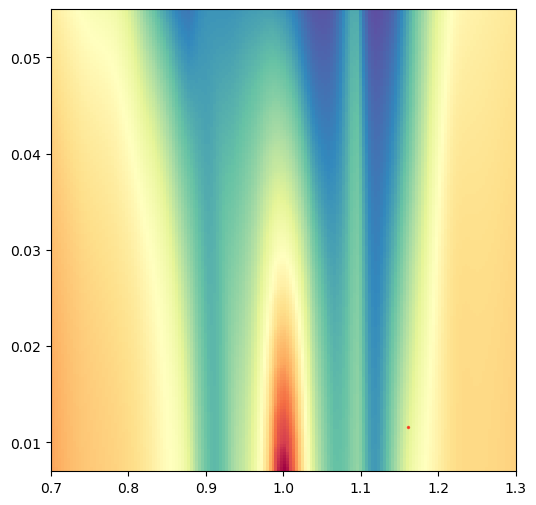

In [4]:

# Cargar los datos de la simulación
df = load_data("XZ", "phi=0", 20)


res = 160 # Resolución de la meshgrid para interpolación

# Definir límites de interpolación
var1_min, var1_max = 0.7, 1.3
var2_min, var2_max = 0.007, 0.055
var1_reg, var2_reg = np.linspace(var1_min, var1_max, res), np.linspace(var2_min, var2_max, res)
VAR1_reg, VAR2_reg = np.meshgrid(var1_reg, var2_reg, indexing='ij')



# Generar partículas
npart = 1  # Número de partículas
df_particles = pd.DataFrame({
    "var1": np.random.uniform(var1_min,var1_max,npart),
    "var2": np.random.uniform(var2_min, var2_max,npart)
})


# Parámetros de integración
ts = 1 # Número de tiempos de integración
t_span = (0, 1)
t_eval = np.linspace(t_span[0], t_span[1], ts)

# Resolver ODEs en paralelo
with tqdm_joblib(desc="Calculando streaklines", total=len(df_particles), unit="punto"):
    df_particles["streakline"] = Parallel(n_jobs=-1)(
        delayed(solve_ivp)(lambda t, y: velocity_field(t, y, df), t_span, point, t_eval=t_eval, method='RK45')
        for point in df_particles[["var1", "var2"]].values
    )

# Animación
fig, ax = plt.subplots(figsize=(6, 6))
camera = Camera(fig)

for frame in tqdm(range(len(t_eval)), desc="Generando animación", unit="frame"):
    time = t_eval[frame]
    gasd_interp= interpolate_density(time, VAR1_reg, VAR2_reg,df)
    
    ax.pcolormesh(VAR1_reg, VAR2_reg, np.log10(gasd_interp * sim.URHO * 1e3),
                   cmap="Spectral_r", shading='auto')
    
    for _, row in df_particles.iterrows():
        ax.plot(row["streakline"].y[0][frame], row["streakline"].y[1][frame], 'ro', markersize=1.45, alpha=0.6)
    
    ax.set_xlim(var1_min, var1_max)
    ax.set_ylim(var2_min, var2_max)
    
    camera.snap()

In [5]:
animation = camera.animate()
animation.save('mphi.mp4', writer=FFMpegWriter(fps=15, codec='libx264', bitrate=5000))
plt.show()

## Plano XY -----> $\theta=1.56 \ [rad]$

Calculando streaklines:   0%|          | 0/1 [00:00<?, ?punto/s]

Generando animación: 100%|██████████| 1/1 [00:01<00:00,  1.26s/frame]


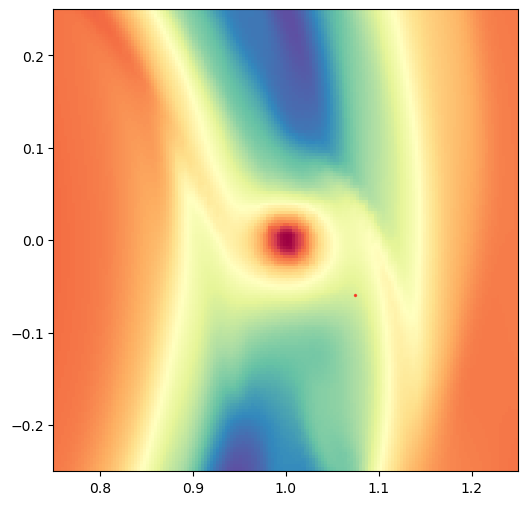

In [8]:
df=load_data("XY", "theta=1.56", 20)


res = 160 # Resolución de la meshgrid para interpolación
var1_min, var1_max = 0.75, 1.25
var2_min, var2_max = -0.25, 0.25
var1_reg, var2_reg = np.linspace(var1_min, var1_max, res),np.linspace(var2_min, var2_max, res)
VAR1_reg, VAR2_reg = np.meshgrid(var1_reg, var2_reg, indexing='ij')




# Generar partículas
npart = 1
df_particles = pd.DataFrame({
    "var1": np.random.uniform(var1_min,var1_max,npart),
    "var2": np.random.uniform(var2_min, var2_max, npart)
})


# Parámetros de integración
ts = 1 # Número de tiempos de integración
t_span = (0, 1)
t_eval = np.linspace(t_span[0], t_span[1], ts)

# Resolver ODEs en paralelo
with tqdm_joblib(desc="Calculando streaklines", total=len(df_particles), unit="punto"):
    df_particles["streakline"] = Parallel(n_jobs=-1)(
        delayed(solve_ivp)(lambda t, y: velocity_field(t, y, df), t_span, point, t_eval=t_eval, method='RK45')
        for point in df_particles[["var1", "var2"]].values
    )

# Animación
fig, ax = plt.subplots(figsize=(6, 6))
camera = Camera(fig)

for frame in tqdm(range(len(t_eval)), desc="Generando animación", unit="frame"):
    time = t_eval[frame]
    gasd_interp = interpolate_density(time, VAR1_reg, VAR2_reg,df)
    
    ax.pcolormesh(VAR1_reg, VAR2_reg, np.log10(gasd_interp * sim.URHO * 1e3),
                   cmap="Spectral_r", shading='auto')
    
    for _, row in df_particles.iterrows():
        ax.plot(row["streakline"].y[0][frame], row["streakline"].y[1][frame], 'ro', markersize=1.45, alpha=0.6)
    
    ax.set_xlim(var1_min, var1_max)
    ax.set_ylim(var2_min, var2_max)
    
    camera.snap()

# Simulación 2

 Para ver trayectorias de partículas que se emiten cada cierto tiempo, con tiempo de integración limitado, distribuidas uniformemente en meshgrid


Generando animación: 100%|██████████| 1/1 [02:41<00:00, 161.13s/frame]


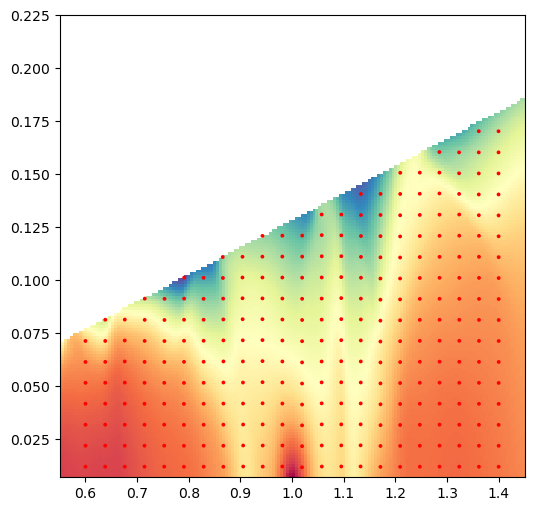

In [5]:
# Cargar los datos de la simulación
df=load_data("XZ","phi=0",20)

# Definir límites de interpolación

res = 160 # Resolución del meshgrid

var1_min, var1_max = 0.55, 1.45
var2_min, var2_max = 0.007, 0.225
var1_reg, var2_reg = np.linspace(var1_min, var1_max, res), np.linspace(var2_min, var2_max,res)
VAR1_reg, VAR2_reg = np.meshgrid(var1_reg, var2_reg, indexing='ij')

# Parámetros de integración de partículas


ts = 1     # Numero de tiempos para integracíon
t_span = (0, 1)
t_eval = np.linspace(t_span[0], t_span[1], ts)


npi = 500  # Número de partículas generadas por intervalo
max_lifetime = 70     # Tiempo de vida máximo de las partículas (en frames)
generation_interval = 20  # Intervalo de tiempo entre generación de partículas (en frames)

# Listas para almacenar posiciones y tiempos de vida de las partículas
particle_pos= [] 
lifetimes = []

# Animación
fig, ax = plt.subplots(figsize=(6, 6))
camera = Camera(fig)




with tqdm(total=len(t_eval), desc="Generando animación", unit="frame") as pbar:
    for frame in range(len(t_eval)):
        time = t_eval[frame]
        
        if frame % generation_interval == 0:
            new_particles = generate_uniform_particles(var1_min,var1_max,var2_min,var2_max, npi,df)
            particle_pos.extend(new_particles)
            lifetimes.extend([max_lifetime] * len(new_particles))
        
        updated_pos = Parallel(n_jobs=-1)(delayed(integrate_particle)(point, time,df) for point in particle_pos)
        updated_pos = [pos for pos in updated_pos if pos is not None]
        updated_lifetimes = [lifetimes[i] - 1 for i, pos in enumerate(updated_pos)]
        
        particle_pos = [pos for i, pos in enumerate(updated_pos) if updated_lifetimes[i] > 0]
        lifetimes = [lifetime for lifetime in updated_lifetimes if lifetime > 0]

        lifetimes_normalized = np.array(lifetimes) / max_lifetime
        
        # Agregar interpolación de densidad como fondo
        gasd_interpolated = interpolate_density(time, VAR1_reg, VAR2_reg,df)
        ax.pcolormesh(VAR1_reg, VAR2_reg, np.log10(gasd_interpolated * sim.URHO * 1e3),
                       cmap="Spectral_r", shading='auto')

        # Graficar partículas
        if particle_pos:
            ax.scatter(*zip(*particle_pos), c='red', alpha=lifetimes_normalized, s=3.0)

        ax.set_xlim(var1_min, var1_max)
        ax.set_ylim(var2_min, var2_max)
        camera.snap()
        
        pbar.update(1)


animation = camera.animate()
animation.save('prueba5.mp4', writer=FFMpegWriter(fps=15, codec='libx264', bitrate=5000))
plt.show()
    
